In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [4]:
# Taken from A3.py file found on the Computer Vision canvas files page

def minbbox(element):
    """
    Takes in a binary mask and returns a minimal bounding box around
    the non-zero elements.
    Input:
    - mask: a mask image (should contain only 0 and non-zero elements)
    Returns:
    - bbox: a list of four points in the form: [min_x, min_y, max_x, max_y]
    """

    vals = np.nonzero(element)
    min_h = vals[0].min()
    max_h = vals[0].max()
    min_w = vals[1].min()
    max_w = vals[1].max()

    return [min_w, min_h, max_w, max_h]

In [5]:
offset = 300

In [6]:
# img_fn is a list of file paths corresponding to a scene captured at varying exposure levels
# exposure levels corresponding to the current set of images can be found in Exposureinfo.txt
img_fn = ["data/9/img-1.tif", "data/9/img-2.tif", "data/9/img-3.tif", "data/9/img-4.tif", "data/9/img-5.tif", "data/9/img-6.tif", "data/9/img-7.tif", "data/9/img-8.tif", "data/9/img-9.tif"]
img_list = [cv.imread(fn) for fn in img_fn]
exposure_times = np.array([(1/8000), (1/4000), (1/2000), (1/1000), (1/500), (1/250), (1/125), (1/60), (1/30)], dtype=np.float32)

log_exposure = [np.log(x) for x in exposure_times]

### Register images

In [7]:
# Convert all images in img_list from RGB to grayscale
gray = [cv.cvtColor(img, cv.COLOR_RGB2GRAY) for img in img_list]

# Normalize all gray scale images using histogram equalization
norm = [cv.equalizeHist(test) for test in gray]

# Use the first normalized image as the reference image for alignment
img1 = norm[0]

# Initalize the output list with the first image (unaltered)
output = [img_list[0]]

# Loop through the rest of the normalized images to align them to the reference image
for i in range(1, len(norm)):
    print(i) # Printing the current image index
    img2 = norm[i] # Storing the current normalized image in img2

    # Create an instance of the AKAZE feature detector
    detector = cv.AKAZE_create()

    # Detecting and computing keypoints for the reference and current images
    kp1, des1 = detector.detectAndCompute(img1, None) # Reference image key points
    kp2, des2 = detector.detectAndCompute(img2, None) # Current image key points

    # Brute force matching the detected keypoints between the reference and current image key points
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck = True)
    matches = bf.match(des1, des2)

    # Storing the matched key points (sorted based on distance)
    matches = sorted(matches, key = lambda x: x.distance)

    # Keeping the top 75% of matches or at least 10 matches
    num_good_matches = int(len(matches) * 0.75)
    matches = matches[:max(num_good_matches, 10)]

    # Getting the coordinates corresponding to the matches from both images
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)

    # Compute the transofrmation matrix
    transformation_matrix, inliers = cv.findHomography(
                pts2, pts1, method=cv.RANSAC, ransacReprojThreshold=3.0, confidence=0.99
            )

    # Warping the current image to align with the reference image via the transformation matrix
    aligned_img = cv.warpPerspective(
                img_list[i], 
                transformation_matrix, 
                (img1.shape[1], img1.shape[0]),
                flags=cv.INTER_LINEAR
            )
    # Add the aligned image to output
    output += [aligned_img]


1
2
3
4
5
6
7
8


In [8]:
masks = []

# Loop through each of the aligned images
for img in output:
    minw, minh, maxw, maxh = minbbox(img) # Get the minimum bounding box for each aligned image
    h, w, _ = img.shape
    mask = np.zeros((h,w), dtype='uint8')

    # Fill the mask based on the dimensions of the minimum bounding box
    mask[minh:maxh, minw:maxw] = np.ones(((maxh-minh), (maxw-minw)), dtype='uint8')
    masks += [mask]

# The first mask is the reference since it acted as the reference image during the alignment process
joined = masks[0]
for mask in masks[1:]:
    # Updating the composite mask with each iteration using a element wise logical and
    joined = np.logical_and(joined, mask)
minw, minh, maxw, maxh = minbbox(joined)

# Shrinking the image with the hyperparameter "offset" to remove any residuals
minw = minw + int(offset / 2)
maxw = maxw - int(offset / 2)
minh = minh + int(offset / 2)
maxh = maxh - int(offset / 2)

cropped = []

# Cropping and saving each of the aligned images
for el in output:
    cropped += [el[minh:maxh, minw:maxw]]

In [9]:
num_samples = 100

# Randomly generating 
samples = [(random.randint(0, cropped[0].shape[0]), random.randint(0, cropped[0].shape[1])) for _ in range(num_samples)]

# Splitting the three channels into seperate color channels
red = [img[:,:,0] for img in cropped]
green = [img[:,:,1] for img in cropped]
blue = [img[:,:,2] for img in cropped]

In [10]:
# Initializing arrays to hold the sampled red channel values
redsample = np.zeros((num_samples, len(cropped)))
for j in range(len(cropped)):
    for i in range(len(samples)):
        redsample[i,j] = red[j][samples[i][0], samples[i][1]]

# Initializing arrays to hold the sampled green channel values
greensample = np.zeros((num_samples, len(cropped)))
for j in range(len(cropped)):
    for i in range(len(samples)):
        greensample[i,j] = green[j][samples[i][0], samples[i][1]]

# Initializing arrays to hold the sampled blue channel values
bluesample = np.zeros((num_samples, len(cropped)))
for j in range(len(cropped)):
    for i in range(len(samples)):
        bluesample[i,j] = blue[j][samples[i][0], samples[i][1]]

In [11]:
def gsolve(Z, B, l, w, midval):
    """
    Solve for imaging system response function.
    
    Given a set of pixel values observed for several pixels in several
    images with different exposure times, this function returns the
    imaging system's response function g as well as the log film irradiance
    values for the observed pixels.
    
    Assumes:
    - Zmin = 0
    - Zmax = 255
    
    Parameters:
    - Z: array of pixel values, Z[i,j] is the pixel value at location i in image j
    - B: array of log delta t (shutter speeds), B[j] for image j
    - l: lambda, the constant that determines the amount of smoothness
    - w: weighting function or array, w[z] gives the weight for pixel value z
    
    Returns:
    - g: log exposure corresponding to pixel value z
    - lE: log film irradiance at pixel location i
    """
    n = 256
    

    A = np.zeros((Z.shape[0] * Z.shape[1] + n + 1, n + Z.shape[0]))
    b = np.zeros((A.shape[0], 1))
    

    k = 0 
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            z_val = Z[i, j]
            wij = w(z_val)
            A[k, int(z_val)] = wij
            A[k, n + i] = -wij
            b[k, 0] = wij * B[j]  
            k += 1
    

    A[k, midval] = 1  # Middle value for 0-indexed array (256/2)
    k += 1
    
    for i in range(n - 2):

        wval = w(i + 1)

        
        A[k, i] = l * wval
        A[k, i + 1] = -2 * l * wval
        A[k, i + 2] = l * wval
        k += 1
    
    x = np.linalg.lstsq(A, b, rcond=None)[0]

    g = x[:n].flatten()
    lE = x[n:].flatten()
    
    return g, lE

In [12]:
def weight_function(z, z_min=0, z_max=255):
    """
    Implements the triangular weighting function as described in the equation:
    
    w(z) = {
        z - z_min       for z <= (z_min + z_max)/2
        z_max - z       for z > (z_min + z_max)/2
    }

    """
    mid_point = 0.5 * (z_min + z_max)
    
    if np.isscalar(z):
        if z <= mid_point:
            return z - z_min
        else:
            return z_max - z
    else:
        z = np.asarray(z)
        weights = np.zeros_like(z, dtype=float)
        
        mask_lower = z <= mid_point
        weights[mask_lower] = z[mask_lower] - z_min
        
        mask_upper = z > mid_point
        weights[mask_upper] = z_max - z[mask_upper]
        
        return weights


In [13]:
def create_radiance_map(images, g, exposure_times, weights):
    radiance_map = np.zeros(images[0].shape)

    for i in range(radiance_map.shape[0]):
        if i % 100 == 0:
            print(str(i) + " of " + str(radiance_map.shape[0]))
        for j in range(radiance_map.shape[1]):
            pixel_values = [images[k][i,j] for k in range(len(images))]
            
            # Equation 6
            numerator = 0
            denominator = 0
            for k in range(len(images)):
                w = weights(pixel_values[k])
                numerator += w * (g[pixel_values[k]] - exposure_times[k])
                denominator += w
            
            # Compute log radiance
            if denominator > 0:
                radiance_map[i,j] = numerator / denominator
            else:
                radiance_map[i,j] = g[pixel_values[0]] - exposure_times[0]
    
    # Convert from log space to linear space
    radiance_map = np.exp(radiance_map)
    return radiance_map

In [14]:
(rg, _) = gsolve(redsample, log_exposure,20, weight_function, 160)
(gg, _) = gsolve(greensample, log_exposure,20, weight_function, 160)
(bg, _) = gsolve(bluesample, log_exposure,20, weight_function, 160)

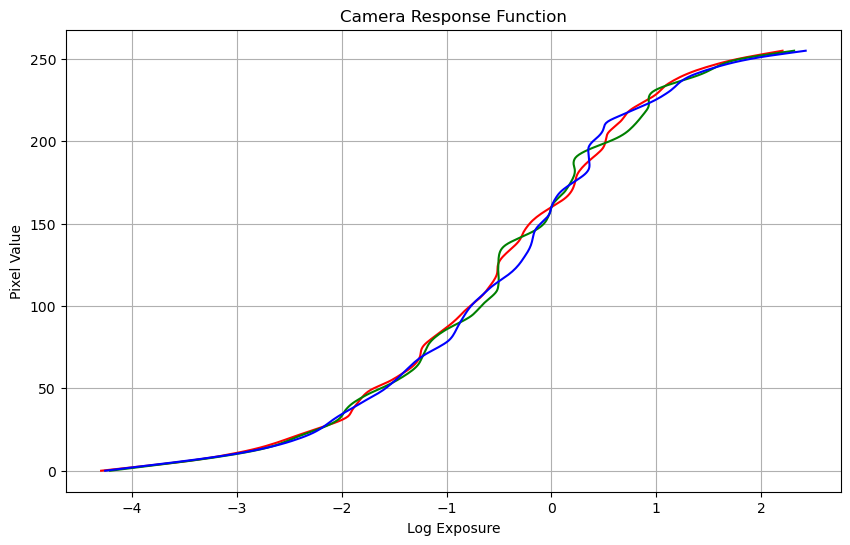

In [ ]:
# Visualizing the camera response function
plt.figure(figsize=(10, 6))
plt.plot(rg, range(256), color = "red")
plt.plot(gg, range(256), color = "green")
plt.plot(bg, range(256), color = "blue")
plt.ylabel('Pixel Value')
plt.xlabel('Log Exposure')
plt.title('Camera Response Function')
plt.grid(True)
plt.show()

In [16]:
rr = create_radiance_map(red, rg, log_exposure, weight_function)
gr = create_radiance_map(green, gg, log_exposure, weight_function)
br = create_radiance_map(blue, bg, log_exposure, weight_function)

0 of 3694
100 of 3694
200 of 3694
300 of 3694
400 of 3694
500 of 3694
600 of 3694
700 of 3694
800 of 3694
900 of 3694
1000 of 3694
1100 of 3694
1200 of 3694
1300 of 3694
1400 of 3694
1500 of 3694
1600 of 3694
1700 of 3694
1800 of 3694
1900 of 3694
2000 of 3694
2100 of 3694
2200 of 3694
2300 of 3694
2400 of 3694
2500 of 3694
2600 of 3694
2700 of 3694
2800 of 3694
2900 of 3694
3000 of 3694
3100 of 3694
3200 of 3694
3300 of 3694
3400 of 3694
3500 of 3694
3600 of 3694
0 of 3694
100 of 3694
200 of 3694
300 of 3694
400 of 3694
500 of 3694
600 of 3694
700 of 3694
800 of 3694
900 of 3694
1000 of 3694
1100 of 3694
1200 of 3694
1300 of 3694
1400 of 3694
1500 of 3694
1600 of 3694
1700 of 3694
1800 of 3694
1900 of 3694
2000 of 3694
2100 of 3694
2200 of 3694
2300 of 3694
2400 of 3694
2500 of 3694
2600 of 3694
2700 of 3694
2800 of 3694
2900 of 3694
3000 of 3694
3100 of 3694
3200 of 3694
3300 of 3694
3400 of 3694
3500 of 3694
3600 of 3694
0 of 3694
100 of 3694
200 of 3694
300 of 3694
400 of 3694
500 

In [17]:
def simple_tonemap(radiance_map):

    log_map = np.log(1 + radiance_map)
    
    normalized = (log_map - np.min(log_map)) / (np.max(log_map) - np.min(log_map))

    return (normalized * 255).astype(np.uint8)

In [ ]:
test = np.zeros((rr.shape[0], rr.shape[1], 3))
test[:,:,0] = rr
test[:,:,1] = gr
test[:,:,2] = br

In [30]:
rt = simple_tonemap(rr)
gt = simple_tonemap(gr)
bt = simple_tonemap(br)

output = np.zeros((rt.shape[0], rt.shape[1], 3))
output[:,:,0] = rt
output[:,:,1] = gt
output[:,:,2] = bt

In [ ]:
cv.imwrite("ldr_test.jpg", output)

[ WARN:0@8339.802] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


True